In [ ]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
from io import StringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PFA/data/google_image_features_cnn.csv', sep=' ', header=None)

data

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,3.762959,1.066455,0.000000,0.068734,2.606900,0.000000,0.000000,0.0,2.135525,0.000000,...,0.000000,0.481353,0.000000,1.044140,3.233006,0.453985,0.000000,0.164270,0.995194,-0.831240
1,3.461088,0.577504,0.137719,0.000000,1.793993,0.000000,0.155270,0.0,1.750664,0.000000,...,0.000000,0.202435,0.012569,0.829805,2.763726,0.709947,0.234883,0.096051,1.572826,-0.739180
2,1.685049,0.799963,0.259948,0.054343,2.899012,0.076634,0.471982,0.0,1.012823,0.003214,...,0.219667,0.606262,0.052912,0.384273,3.225660,1.313704,0.267143,0.330666,0.803811,-0.786210
3,2.516893,1.342928,0.146925,0.147441,3.080560,0.021404,0.376827,0.0,1.345461,0.000000,...,0.000000,0.481120,0.067072,0.285141,3.679513,1.542571,0.333537,0.172083,0.694663,-0.447090
4,2.119679,0.988949,0.267445,0.147844,2.988878,0.031124,0.414400,0.0,1.117143,0.121500,...,0.000000,0.497015,0.000000,0.736928,3.513838,1.485018,0.369814,0.038970,1.657693,-0.687435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,1.037815,1.213302,0.320115,0.387684,1.418909,0.012873,0.230272,0.0,0.605992,0.054552,...,0.025539,0.517890,0.363778,0.311068,2.541128,0.941297,0.000000,0.241105,0.031031,1.757480
591,0.874353,1.100232,0.293290,0.409337,1.216099,0.013678,0.222244,0.0,0.539924,0.057962,...,0.027135,0.538566,0.363502,0.203107,2.529256,0.947276,0.000000,0.264069,0.032970,1.591590
592,1.192760,1.271527,0.452483,0.457338,1.503539,0.016834,0.301125,0.0,0.565414,0.024843,...,0.000000,0.397369,0.475710,0.281941,3.063010,1.180715,0.000000,0.241621,0.040579,2.281590
593,1.283901,1.213771,0.325421,0.695469,1.428614,0.019895,0.293026,0.0,0.988357,0.000000,...,0.018470,0.543789,0.253988,0.164165,3.182858,0.815982,0.000000,0.387963,0.119917,-0.042325


In [ ]:
def read_raster(raster_file):
    """
    Function
    --------
    read_raster

    Given a raster file, get the pixel size, pixel location, and pixel value

    Parameters
    ----------
    raster_file : string
        Path to the raster file

    Returns
    -------
    x_size : float
        Pixel size
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    centroid_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the centroid in each pixel
    centroid_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the centroid in each pixel
    bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
        Pixel value
    """

    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform

    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)

# Helper function to get the pixel index of the point
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    """
    Function
    --------
    get_cell_idx

    Given a point location and all the pixel locations of the raster file,
    get the column and row index of the point in the raster

    Parameters
    ----------
    lon : float
        Longitude of the point
    lat : float
        Latitude of the point
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel

    Returns
    -------
    lon_idx : int
        Column index
    lat_idx : int
        Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [ ]:
raster_file = '/content/drive/MyDrive/PFA/data/F182013.v4c_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

# save the result in compressed format - see https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html
np.savez('/content/drive/MyDrive/PFA/data/tunis/nightlight.npz', top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords, bands_data=bands_data)

In [ ]:
# get nightlight features for each cluster
def get_nightlight_feature(sample):
    idx, wealth, x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    # Select the 10 * 10 pixels
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    luminosity_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            # Get the luminosity of this pixel
            luminosity = bands_data[j, i, 0]
            luminosity_100.append(luminosity)
    luminosity_100 = np.asarray(luminosity_100)
    max_ = np.max(luminosity_100)
    min_ = np.min(luminosity_100)
    mean_ = np.mean(luminosity_100)
    median_ = np.median(luminosity_100)
    std_ = np.std(luminosity_100)
    return pd.Series({'id': idx, 'max_': max_, 'min_': min_, 'mean_': mean_,
                      'median_': median_, 'std_': std_, 'wealth': wealth})


clusters = pd.read_csv('/content/drive/MyDrive/PFA/data/tunis/tun_relative_wealth_index.csv', delimiter=';')
data_all = clusters.apply(lambda x: get_nightlight_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)
data_all.to_csv('/content/drive/MyDrive/PFA/data/tunis/DHS_nightlights.csv', index=None)

In [ ]:
data_all.head()

,id,max_,min_,mean_,median_,std_,wealth
0,1.0,18.0,0.0,4.56,5.0,3.527946,-0.224
1,2.0,23.0,0.0,6.83,5.0,6.141751,-0.338
2,3.0,6.0,0.0,1.00,0.0,1.959592,-0.501
3,4.0,0.0,0.0,0.00,0.0,0.000000,-0.403
4,5.0,56.0,0.0,11.28,8.0,12.453979,-0.156


(0.0, 50.0)

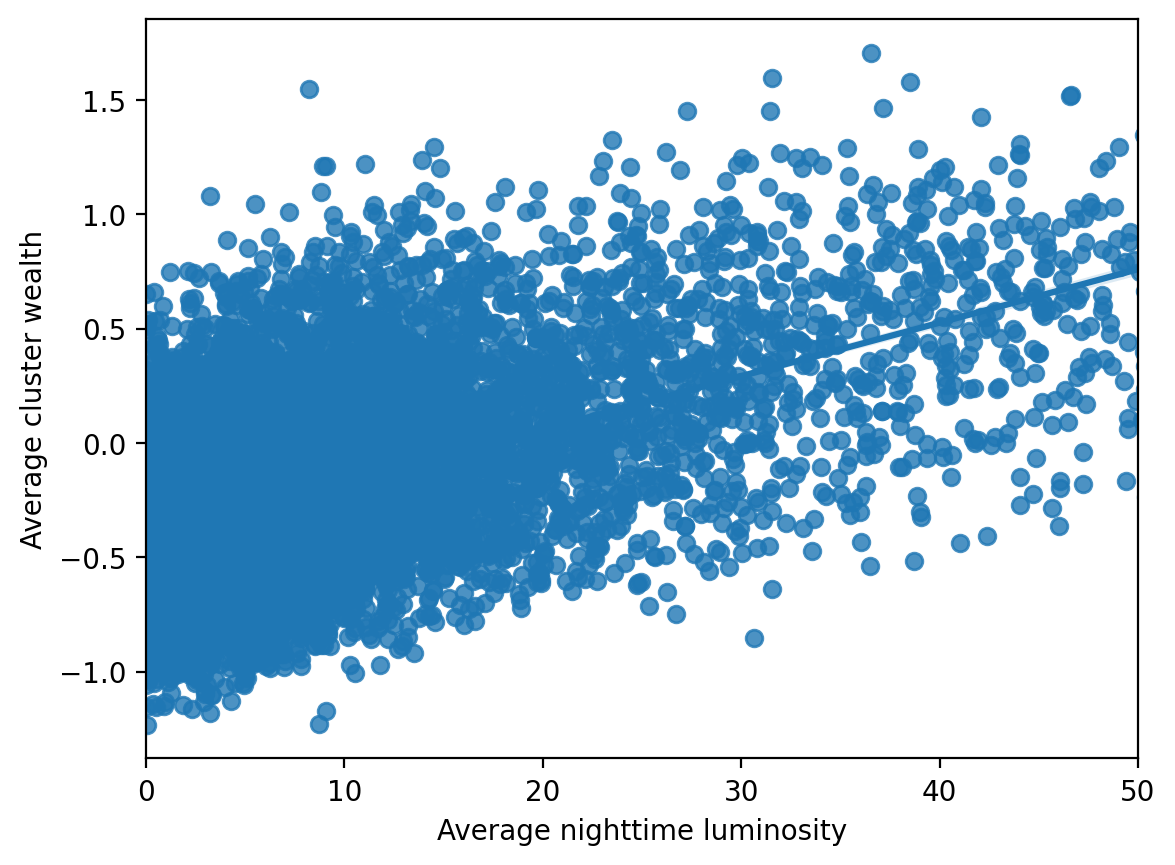

In [ ]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

ax = sns.regplot(x="mean_", y="wealth", data=data_all)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
plt.xlim([0, 50])

In [ ]:
data_all

,id,max_,min_,mean_,median_,std_,wealth
0,1.0,18.0,0.0,4.56,5.0,3.527946,-0.224
1,2.0,23.0,0.0,6.83,5.0,6.141751,-0.338
2,3.0,6.0,0.0,1.00,0.0,1.959592,-0.501
3,4.0,0.0,0.0,0.00,0.0,0.000000,-0.403
4,5.0,56.0,0.0,11.28,8.0,12.453979,-0.156
...,...,...,...,...,...,...,...
14896,14897.0,5.0,0.0,0.25,0.0,1.089725,-0.296
14897,14898.0,45.0,0.0,6.13,0.0,9.606930,-0.092
14898,14899.0,5.0,0.0,0.42,0.0,1.342982,-0.322
14899,14900.0,0.0,0.0,0.00,0.0,0.000000,-0.560


In [ ]:
#fit a model of wealth as a function of nightlights

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X=data_all.drop(['id','wealth'], axis=1)
y=data_all['wealth']
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,)


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.neural_network import MLPRegressor

SEED=2
np.random.seed(SEED)

In [ ]:
def train_test_model(X_train,X_test,y_train,y_test,model):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  results=pd.DataFrame(index=[model.__class__.__name__])
  results['RMSE']= MSE(y_test,y_pred)**0.5
  results['R2']= r2_score(y_test,y_pred)
  display(results)

In [ ]:
lr = LinearRegression()
ridge= Ridge()
lasso = Lasso()
elasticnet=ElasticNet()
gradient_boost=GradientBoostingRegressor(n_estimators=300,random_state=SEED)
rf= RandomForestRegressor(random_state=SEED)
knn= KNeighborsRegressor(n_neighbors=2)
nn= MLPRegressor( random_state=SEED,max_iter=500)

models=[ lr , ridge , lasso,elasticnet, gradient_boost , rf , knn , nn ]
for model in models:
  train_test_model(X_train, X_test, y_train, y_test, model)
#here we choose the best model
model = nn

,RMSE,R2
LinearRegression,0.322035,0.367212


,RMSE,R2
Ridge,0.322035,0.367212


,RMSE,R2
Lasso,0.343713,0.279151


,RMSE,R2
ElasticNet,0.329278,0.338424


,RMSE,R2
GradientBoostingRegressor,0.316448,0.388976


,RMSE,R2
RandomForestRegressor,0.333851,0.319924


,RMSE,R2
KNeighborsRegressor,0.375016,0.14187


,RMSE,R2
MLPRegressor,0.318451,0.381218


In [ ]:
import pandas as pd

data = {
    'Latitude': [36.8065, 35.8254, 34.7397, 33.8782, 37.2721, 35.7771, 35.6779, 36.8982, 35.1899, 34.7340,
                 33.8191, 37.0194, 35.5175, 36.8000, 34.4250, 33.8936, 36.8663, 35.7393, 34.6086, 33.7572,
                 37.1014, 35.8978, 35.1676, 34.7025, 33.8694, 36.5097, 35.8289, 35.2935, 34.8251, 33.8847,
                 36.4453, 35.8248, 35.4260, 34.8111, 33.9716, 36.8156, 35.8200, 35.4722, 34.8206, 33.9000,
                 36.8996, 35.7806, 35.4972, 34.7525, 33.8764, 36.8972, 35.8447, 35.4408, 34.7172, 33.8783],
    'Longitude': [10.1815, 10.6363, 10.7598, 10.0982, 9.8709, 10.8275, 10.1012, 10.1897, 10.1679, 10.7570,
                  10.8197, 9.1687, 10.5272, 10.1833, 10.5000, 10.0094, 10.1696, 10.6249, 10.4876, 10.7536,
                  9.4892, 10.7144, 10.4300, 10.6333, 10.8212, 10.2211, 10.6025, 10.3997, 10.9819, 10.0250,
                  10.4876, 10.6118, 10.5980, 10.6286, 10.7853, 10.1800, 10.6222, 10.6472, 10.6356, 10.1250,
                  10.1675, 10.6475, 10.6467, 10.4569, 10.5419, 10.1378, 10.1917, 10.6089, 10.7950, 10.7814]
}

df = pd.DataFrame(data)

In [ ]:
# get nightlight features for each cluster
def get_nightlight_feature(sample):
    x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    # Select the 10 * 10 pixels
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    luminosity_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            # Get the luminosity of this pixel
            luminosity = bands_data[j, i, 0]
            luminosity_100.append(luminosity)
    luminosity_100 = np.asarray(luminosity_100)
    max_ = np.max(luminosity_100)
    min_ = np.min(luminosity_100)
    mean_ = np.mean(luminosity_100)
    median_ = np.median(luminosity_100)
    std_ = np.std(luminosity_100)
    return pd.Series({'max_': max_, 'min_': min_, 'mean_': mean_,
                      'median_': median_, 'std_': std_,'Longitude':x, 'Latitude':y })


prediction = df.apply(lambda x: get_nightlight_feature([x['Longitude'], x['Latitude']]), axis=1)
prediction.head()

,max_,min_,mean_,median_,std_,Longitude,Latitude
0,63.0,52.0,62.18,63.0,2.056113,10.1815,36.8065
1,63.0,12.0,57.13,63.0,11.843695,10.6363,35.8254
2,63.0,12.0,55.95,63.0,12.797168,10.7598,34.7397
3,63.0,18.0,54.85,61.5,11.628736,10.0982,33.8782
4,63.0,8.0,52.12,59.0,14.139505,9.8709,37.2721


In [ ]:
prediction['predicted_wealth']= model.predict(prediction[['max_', 'min_', 'mean_', 'median_','std_']])


In [ ]:
prediction.head()

,max_,min_,mean_,median_,std_,Longitude,Latitude,predicted_wealth
0,63.0,52.0,62.18,63.0,2.056113,10.1815,36.8065,0.997867
1,63.0,12.0,57.13,63.0,11.843695,10.6363,35.8254,1.085176
2,63.0,12.0,55.95,63.0,12.797168,10.7598,34.7397,1.032069
3,63.0,18.0,54.85,61.5,11.628736,10.0982,33.8782,0.929538
4,63.0,8.0,52.12,59.0,14.139505,9.8709,37.2721,0.958735


In [ ]:
#Install libraries for geospatial data wrangling and analysis

#Geopandas for wrangling
!pip install geopandas


#Contextily for basemap plotting
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip3 install contextily==1.0rc2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libproj-dev is already the newest version (8.2.1-1).
libproj-dev set to manually installed.
proj-data is already the newest version (8.2.1-1).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 154 kB of archives.
After this operation, 492 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 proj-bin amd64 8.2.1-1 [154 kB]
Fetched 154 kB in 0s (726 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 120895 files and directories currently installed.)
Preparing to unpack .../proj-bin_8.2.1-1_amd64.deb ...
Unpacking proj-bin (8.2.1-1) ...
Setting up proj-bin (8.2.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state informatio

In [ ]:
c=data_all.merge(clusters, left_on='id', right_on='cluster')

In [ ]:
import geopandas
import pandas as pd
import numpy as np
from geopandas import GeoDataFrame
import geopandas
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
import contextily
c['predicted_wealth']= c['wlthindf']
clusters_df = geopandas.GeoDataFrame(c, geometry = geopandas.points_from_xy(c.longitude, c.latitude))
clusters_df.head()


,id,max_,min_,mean_,median_,std_,wealth,cluster,latitude,longitude,wlthindf,error,predicted_wealth,geometry
0,1.0,18.0,0.0,4.56,5.0,3.527946,-0.224,1,33.495597,10.535889,-0.224,0.497,-0.224,POINT (10.53589 33.49560)
1,2.0,23.0,0.0,6.83,5.0,6.141751,-0.338,2,35.755428,9.876709,-0.338,0.448,-0.338,POINT (9.87671 35.75543)
2,3.0,6.0,0.0,1.00,0.0,1.959592,-0.501,3,33.568861,9.832764,-0.501,0.314,-0.501,POINT (9.83276 33.56886)
3,4.0,0.0,0.0,0.00,0.0,0.000000,-0.403,4,36.040215,8.536377,-0.403,0.380,-0.403,POINT (8.53638 36.04022)
4,5.0,56.0,0.0,11.28,8.0,12.453979,-0.156,5,36.129001,10.469971,-0.156,0.577,-0.156,POINT (10.46997 36.12900)


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


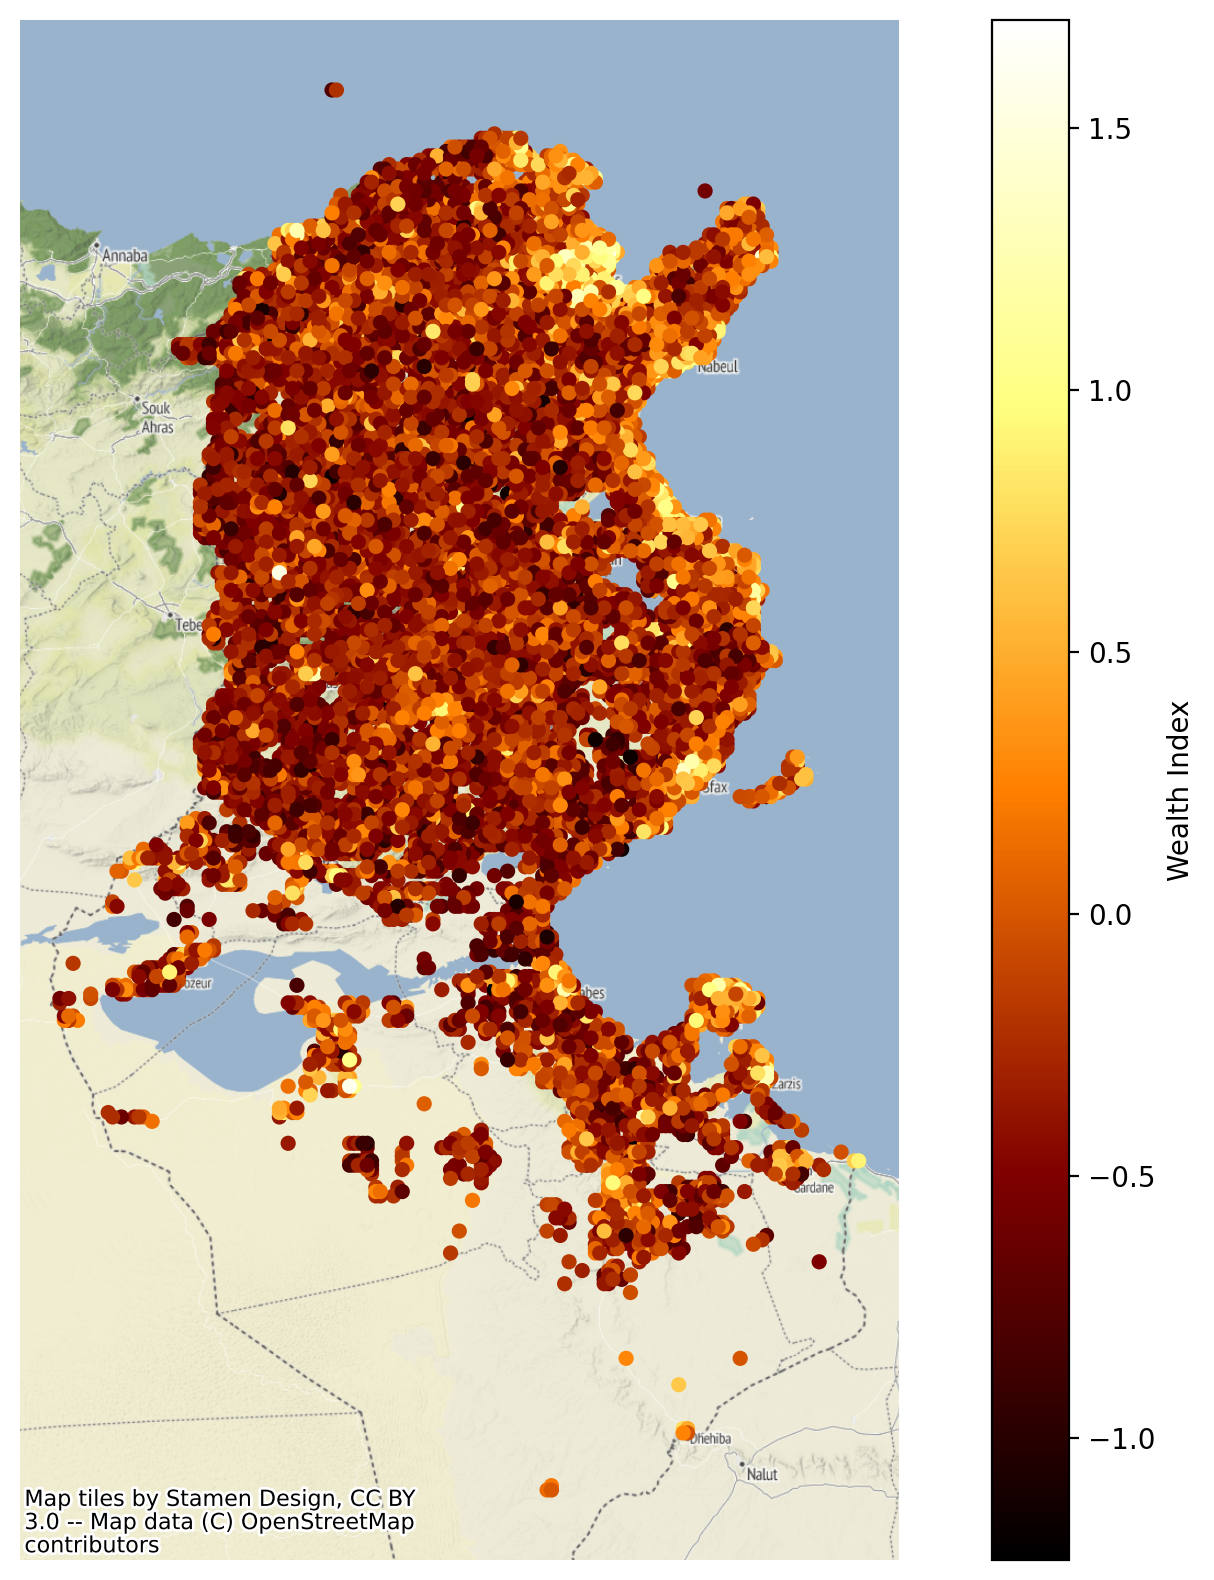

In [ ]:
clusters_df.crs = {'init' :'epsg:4326'}
#clusters_dfcopy.to_crs({'init': 'epsg:3395'})
lgnd_kwds = {'label': "Wealth Index",}

#fig, ax = plt.subplots(figsize=(12, 10))
#plt.xlim(88, 93)
#plt.ylim(20, 28)
#clusters_df = clusters_df.to_crs(epsg=3857)
# ax_clusters = clusters_df.to_crs(epsg=3857).plot(column = 'wealth_predicted', legend=True, scheme='QUANTILES', k=3, figsize=(12, 10), markersize = 20)
ax_clusters = clusters_df.to_crs(epsg=3857).plot(column = 'predicted_wealth', legend=True, legend_kwds = lgnd_kwds, figsize=(12, 10), markersize = 20, cmap='afmhot')
#roads_plot = roads_df.plot(ax = ax)
contextily.add_basemap(ax_clusters)
# contextily.add_basemap(ax_clusters)
ax_clusters.set_axis_off()
plt.show()

In [ ]:
!pip install mapclassify


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


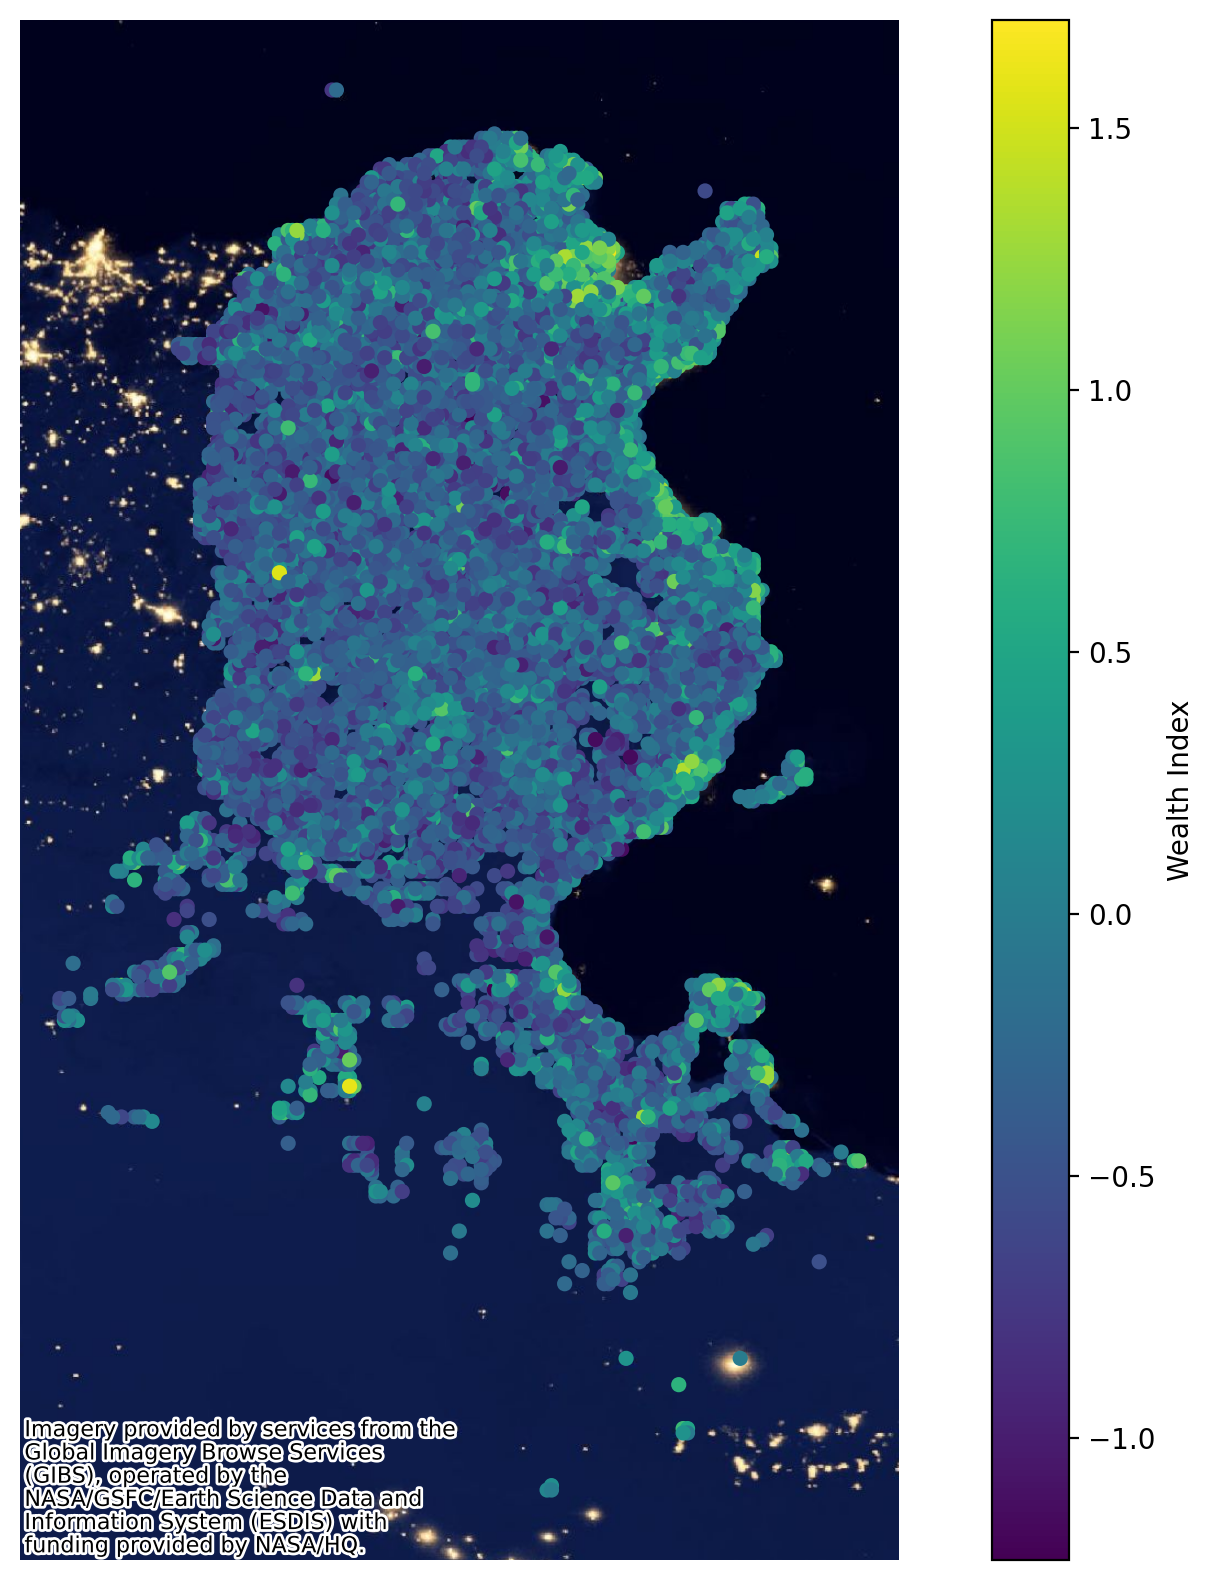

In [ ]:
clusters_df.crs = {'init' :'epsg:4326'}
#clusters_dfcopy.to_crs({'init': 'epsg:3395'})
lgnd_kwds = {'label': 'Wealth Index'}

#fig, ax = plt.subplots(figsize=(12, 10))
#plt.xlim(88, 93)
#plt.ylim(20, 28)
#clusters_df = clusters_df.to_crs(epsg=3857)
# ax_clusters = clusters_df.to_crs(epsg=3857).plot(column = 'wealth_predicted', legend=True, scheme='QUANTILES', k=4, figsize=(12, 10), markersize = 20)
ax_clusters = clusters_df.to_crs(epsg=3857).plot(column = 'predicted_wealth', legend=True, legend_kwds = lgnd_kwds, figsize=(12, 10), markersize = 20, cmap='viridis')
#roads_plot = roads_df.plot(ax = ax)
contextily.add_basemap(ax_clusters, url=contextily.providers.NASAGIBS.ViirsEarthAtNight2012)
# contextily.add_basemap(ax_clusters)

ax_clusters.set_axis_off()
plt.show()
